# Introduction

The European Transaction Log (EUTL) is the backbone of the European Union Emissions Trading System (EUETS). It implements the transfer of emission allowances between parties active in the EUETS. The EUTL provides data on regulated installations, their emissions as well as transfers of allowances.  

Assuming that the database has been successfully populated with the EUTL data (see 1_create_database.ipynb), this notebook illustrates how to analyze compliance and transactions of a single installation.

As a starting point, we assume that the installation identifier is known. The most easy way to find the identifier is going to www.EUETS.INFO/installations and use the search field.

Specifically, we consider the Niederaussem Power Station with installation identifier DE_1649. To analyze another installation, simply change the assignment determining the installation identifier (but the text most likely no longer fits;).

The analysis takes place in three steps:
1. Use the installation identifier to get the installation object.
2. The installation object provides methods to obtain compliance and surrendering details as well as associated accounts
3. Account objects provide methods to assess related transactions.

In [1]:
id_inst = "PL_1"

# Packages and options

In [2]:
from pyeutl.orm import DataAccessLayer    # data access layer to access the database
from pyeutl.orm import Installation       # EUETS Installation object
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Database connection settings

In [3]:
connectionSettings = dict(
    user="postgres", 
    host="localhost", 
    db="eutl2024", 
    passw="password",
    port=5432
)

# Connect to database

Connect to database and get a session:

In [4]:
dal = DataAccessLayer(**connectionSettings)
session = dal.session

# Get installation

Given the installation id, use the session to query the installation:

In [5]:
inst = session.get(Installation, id_inst)
print(inst.id + ": " + inst.name)
print(inst.address)
print("Activity:", inst.activity)

PL_1: PGE GiEK S.A. Oddział Elektrownia Bełchatów
Wola Grzymalina 3
97-406 Bełchatów
Poland
Activity: Combustion of fuels


# Analyze compliance

Compliance is a property of the installation. For convenience, .get_compliance() provides the compliance as pandas DataFrame. 

Due to linking with the Swiss Emissions Trading System, compliance might be reported in the Swiss system. Since is the case only for aircraft operators, we simply drop the respective column: 

In [6]:
inst.compliance
df_compliance = inst.get_compliance().drop("reportedInSystem_id", axis=1)
df_compliance[["year", "allocatedTotal", "verified", "surrendered"]].set_index("year").div(1000000)

,allocatedTotal,verified,surrendered
year,,,
2005,30.794300,31.970055,31.970055
2006,30.794300,30.083123,30.083123
2007,30.794300,28.322323,28.322323
2008,26.937155,30.862792,30.862792
2009,26.937155,29.473072,29.473072
2010,26.937155,29.659590,29.659590
2011,26.937155,32.823146,32.823146
2012,31.749901,35.193844,35.193844
2013,16.816401,37.178165,37.178165


To get a first impression, plot compliance, i.e., allocated and surrendered allowances and verified emissions over time:

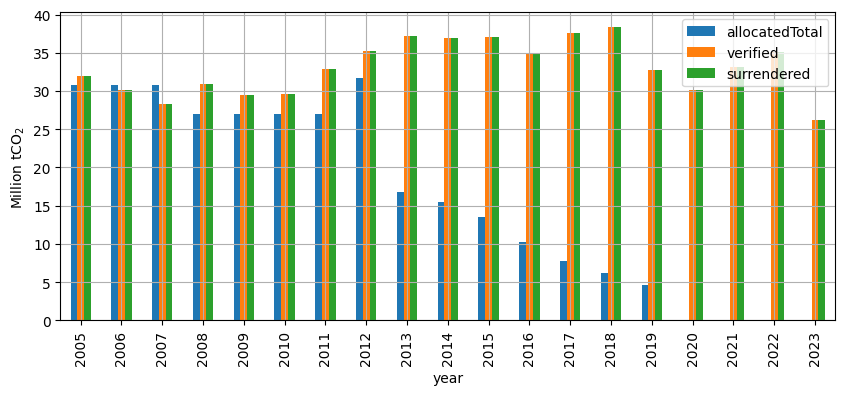

In [7]:
ax = (
    df_compliance
    [["year", "allocatedTotal", "verified", "surrendered"]]
    .query("year < 2024")
    .set_index("year").div(1000000)
    .plot(kind="bar", figsize=(10,4), ylabel="Million tCO$_2$", grid=True)
)

# Surrendering

The installation was in need to acquire additional allowances to be compliant with the EUETS. This offers the question, which allowances have been surrendered. For the first two periods (2005-2007, 2008-2012) the EUTL reports the type of allowances surrendered (e.g., EUA, CER, ERU) as well as the country in which the surrendered certificate has been created. 

Technically, surrendering unit details are also accessible through the installation object (property: surrendering) and the method get_surrendering() provides a Pandas dataframe:

For periods prior to 2013 we observe the country of origin for surrendered units: 

In [8]:
inst.get_surrendering()

,reportedInSystem_id,year,amount,installation_id,unitType_id,originatingRegistry_id,project_id,unitType
0,euets,2021,16562269,PL_1,EUA_2013,None,NaN,EU General Allowances (EUA)
1,euets,2021,16598963,PL_1,EUA_2013,None,NaN,EU General Allowances (EUA)
2,euets,2022,19891556,PL_1,EUA_2013,None,NaN,EU General Allowances (EUA)
3,euets,2022,15172448,PL_1,EUA_2013,None,NaN,EU General Allowances (EUA)
4,euets,2023,7330277,PL_1,EUA_2013,None,NaN,EU General Allowances (EUA)
5,euets,2023,18917960,PL_1,EUA_2013,None,NaN,EU General Allowances (EUA)
6,euets,2013,37178165,PL_1,EUA_2013,None,NaN,EU General Allowances (EUA)
7,euets,2014,36886458,PL_1,EUA_2013,None,NaN,EU General Allowances (EUA)
8,euets,2015,37051920,PL_1,EUA_2013,None,NaN,EU General Allowances (EUA)
9,euets,2016,34941622,PL_1,EUA_2013,None,NaN,EU General Allowances (EUA)


originatingRegistry_id
AR           0.037000
BR           0.081459
CN           0.126278
IN           0.071000
PL         120.873293
Unknown    332.119600
dtype: float64

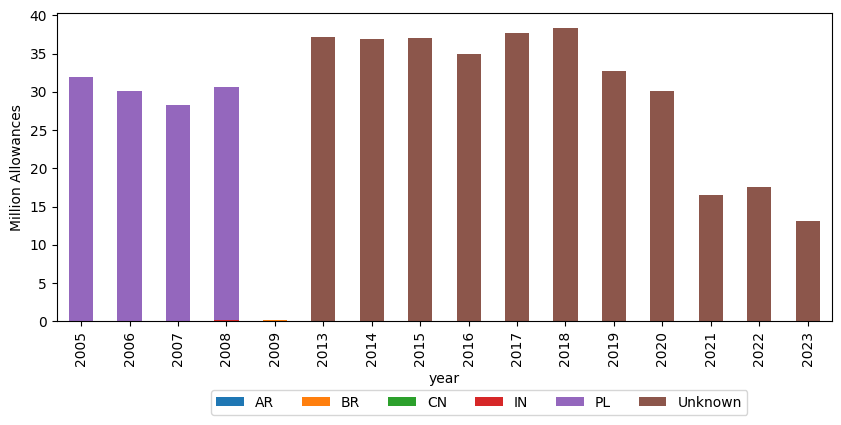

In [9]:
df_p = (
    inst
    .get_surrendering()
    [["year", "originatingRegistry_id", "amount"]]
    .assign(originatingRegistry_id=lambda x: x.originatingRegistry_id.fillna("Unknown"))
    .pivot_table("amount", "year", "originatingRegistry_id")
    .div(1000000)
)

ax = df_p.plot(kind="bar", stacked=True,  figsize=(10,4),)
ax.legend(bbox_to_anchor=(0.9, -0.2), loc=0, ncol=8)
ax.set_ylabel("Million Allowances")
df_p.sum()

For 2009, the surrendering data seem to have missing values. 

# Accounts

Our installation shows some variety of allowances used for surrendering. We now turn to the question, how the installation acquired these allowances. To find an answer to this this questions, we need to examine the transaction behavior of related <i>Accounts</i>.

The EUETS implements emissions trading. Industrial plants regulated are called <i>Installations</i>. Each installation has to be related to an accounts. These accounts might (and are likely to) change over time but at each instance in time an installation is represented by an account. Accounts are the backbone of the trading system, i.e., allowances are transferred between accounts not between installations. Accounts related to installations are called operator holding accounts. As transfers of allowances take place at the account level, we need to find out which accounts represent our installation.

Technically, related accounts are again implemented as property on the installation object (property: accounts). Accounts related to installations are called operator holding accounts (oha):

In [10]:
ohas = inst.accounts
ohas

[<Account(92917, 'PGE GiEK S.A. Oddział Elektrownia Bełchatów', 'PL', '100-7')>,
 <Account(20128, 'PGE Górnictwo i Energetyka Konwencjonalna S.A.', 'PL', '120-0')>]

There are two different accounts. 120-0 denotes former operator holding accounts whereas 100-7 denotes the operating holding account. This account structure is common for installations that have been regulated under the EUETS already before 2013. Due to the change in the EUTL, all installation had to convert their account from 120-0 to 100-7 accounts. Consequently, our 2005 analysis has to focus in the 120-0 account with the meaningful name "Operator Account".

## Getting transactions

Transactions are provided as property on the respective account (property: transactions). To separate transaction by whether the selected account is acquiring or transferring allowances, separate transactions exist (acquiringTransactions, transferringTransactions). get_transactions() provides again a Pandas dataframe with transaction by the respective account.

In [11]:
df_trans = pd.concat([o.get_transactions() for o in ohas]).sort_index()
df_trans.info()
#df_trans

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1146 entries, 2007-02-21 12:30:24 to 2021-04-15 13:57:04
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   transferringYear                 0 non-null      object 
 1   amount                           1146 non-null   int64  
 2   transactionID                    1146 non-null   object 
 3   transactionTypeMain_id           1146 non-null   int64  
 4   transactionTypeSupplementary_id  1146 non-null   int64  
 5   tradingSystem_id                 1146 non-null   object 
 6   transferringAccount_id           1146 non-null   int64  
 7   acquiringAccount_id              1146 non-null   int64  
 8   id                               1146 non-null   int64  
 9   unitType_id                      1146 non-null   object 
 10  acquiringYear                    0 non-null      object 
 11  project_id                       917 non-null 

Overall we observe over 1144 entries in the transaction data. However, that does not mean that the transaction was involved in 1144 transactions. If a transaction involves different unit types or units from different origins, this is reported as a row in the transaction data. To see the number of transactions carried out, we count the number of transactionIDs as provided by the EUTL: 

In [12]:
print("Number of transactions: %d" % len(df_trans["transactionID"].unique()))

Number of transactions: 586


So only 584 transactions have been carried out. Before continuing to analyze the first year of transaction activities, we show how to calculate allowance holdings over time.

## Allowances holdings

The dataframe contains a column "direction" which equals 1 if the account is 
acquiring and -1 if the account is transferring allowances. The column "amount_directed" 
contains the amount of each transaction multiplied by the direction. 
We can use it plot transfers over time and also the cumulative allowance holding. 

Since allowances have not been transferrable from the 2005 to 2007 period, 
we exclude all transactions with the unit type "EUA2005" that indicates units 
used in the trial period. Moreover, we exclude the banking transaction. These
transactions took place between 2012 and 2013 and should be a transformation of
unit types. However, it seems that only the handing of allowances to the EU
commission is in the data but the corresponding transfer back seems to be missing.
Therefore, we exclude transactions with supplementary type 34. 


(14190.603854166666, 18732.581296296295)

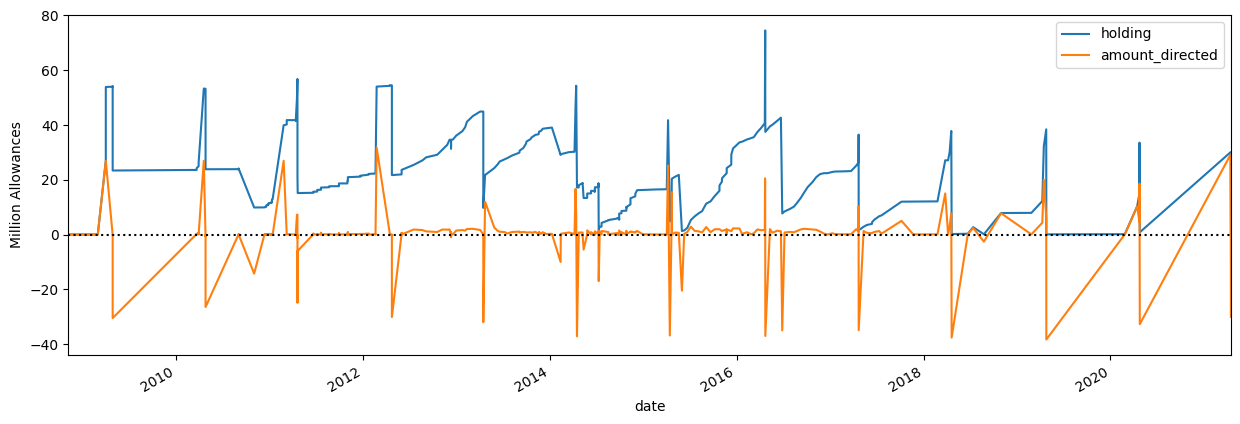

In [13]:
df_ = (
    df_trans
    .query("unitType_id != 'EUA2005'")
    .query(f"transactionTypeSupplementary_id != 34")
    .assign(
        amount_directed=lambda df: df[["amount_directed"]]/1000000,
        holding=lambda df: df[["amount_directed"]].cumsum()
    )
)
df_
ax = df_[["holding", "amount_directed"]].plot( figsize=(15,5), ylabel="Million Allowances")
lims = (df_.index.min(), df_.index.max())
ax.hlines(0, *lims, colors="k", ls=":")
ax.set_xlim(*lims)

## Transactions

Lets finally take a closer look at transactions in the first, trial period of the EUETS
from 2005 to 2007. We filter on these transactions using the unit type "EUA2005".
We do not aim to track the origin of allowances and, thus, aggregate data to transactions that took place.

In [14]:
(   df_trans
    .reset_index()
    .query("unitType_id == 'EUA2005'")
    .groupby(
        ["date", "transactionID", "transactionTypeMain", 
         "transactionTypeSupplementary", "transferringAccountName", 
         "unitType_id",
         "transferringAccountType", "acquiringAccountName", "acquiringAccountType"], 
         as_index=False)
    .amount_directed
    .sum()
    .set_index("date")
    .sort_index()
)

,transactionID,transactionTypeMain,transactionTypeSupplementary,transferringAccountName,unitType_id,transferringAccountType,acquiringAccountName,acquiringAccountType,amount_directed
date,,,,,,,,,
2007-02-21 12:30:24,PL3180,Internal - Internal transfer of unit/supplemen...,Allowance allocation,Krajowy rachunek wydawania uprawnień,EUA2005,Party Holding Account,PGE Górnictwo i Energetyka Konwencjonalna S.A.,Former Operator Holding Account,30794300
2007-02-21 12:40:08,PL3194,Internal - Internal transfer of unit/supplemen...,Allowance allocation,Krajowy rachunek wydawania uprawnień,EUA2005,Party Holding Account,PGE Górnictwo i Energetyka Konwencjonalna S.A.,Former Operator Holding Account,30794300
2007-02-21 12:41:37,PL3202,Internal - Internal transfer of unit/supplemen...,Allowance surrender,PGE Górnictwo i Energetyka Konwencjonalna S.A.,EUA2005,Former Operator Holding Account,Krajowy rachunek umorzenia,Party Holding Account,-31970055
2007-02-26 09:13:05,PL3219,Internal - Internal transfer of unit/supplemen...,Allowance allocation,Krajowy rachunek wydawania uprawnień,EUA2005,Party Holding Account,PGE Górnictwo i Energetyka Konwencjonalna S.A.,Former Operator Holding Account,30794300
2007-04-20 11:27:12,PL4689,Internal - Internal transfer of unit/supplemen...,Allowance surrender,PGE Górnictwo i Energetyka Konwencjonalna S.A.,EUA2005,Former Operator Holding Account,Krajowy rachunek umorzenia,Party Holding Account,-30083123
2008-04-11 11:33:01,PL6642,Internal - Internal transfer of unit/supplemen...,Allowance surrender,PGE Górnictwo i Energetyka Konwencjonalna S.A.,EUA2005,Former Operator Holding Account,Krajowy rachunek umorzenia,Party Holding Account,-28322323


We can observe a typical problem related to the 2005-2007 trial period. The first four 
transactions are surrendering and allocation transfers that relate to earlier years
but are booked in 2007 and should have been booked earlier. E.g., the first transaction
is the 2005 allocation of allowances and should have taken place in the year 2005.

# Conclusions

This notebook shows how the EUTL database provided by EUETS.INFO can be used to analyze compliance and transaction behavior of a single installation. The analysis takes place in three steps:
1. Use the installation identifier to get the installation object.
2. The installation object provides methods to obtain compliance and surrendering details as well as associated accounts
3. Account objects provide methods to assess related transactions.